In [1]:
%load_ext autoreload
%autoreload 2
%run prerun.py
%matplotlib inline

device = torch.device('cuda:2')

SOLVERS:  ['dopri5', 'bdf', 'rk4', 'midpoint', 'adams', 'explicit_adams', 'fixed_adams']
{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


In [2]:
sys.path.append("../")
from model import YModel
from utils import sample_noise, iterate_minibatches, generate_local_data, generate_local_data_lhs
from optim import find_psi, InputOptimisation, make_figures
from utils import DistPlotter
from IPython.display import clear_output

y_sampler = YModel()

In [3]:
n_samples_per_dim = 2000
grad_step = 2.
n_lhc_samples = 5

In [4]:
make_model = lambda : build_model_tabular(dims=1, 
                            condition_dim=3,
                            layer_type='concat_v2',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='rk4',
                            hidden_dims=(32, 32),
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=None).to(device)

In [5]:
def train_flow(model, data, inputs):
    trainable_parametrs = list(model.parameters()) 
    optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-3)

    for epoch in range(300):
        loss = compute_loss(model, data=data, condition=inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

In [6]:
optim_epochs = 5000

In [7]:
class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = generator_model

    def forward(self, noise, inputs):
        return self.gen(noise, inputs)

In [8]:
def end_to_end_training(current_psi):
    r_values = []
    psi_values = []
    x_dim = 1
    try:
        total_epoch_counter = [0]
        for optim_epoch in range(optim_epochs): 
            print(optim_epoch)
            generator = make_model()
            data, inputs = generate_local_data_lhs(y_sampler, device,
                                                   n_samples_per_dim=n_samples_per_dim,
                                                   step=grad_step,
                                                   current_psi=current_psi, 
                                                   x_dim=x_dim,
                                                   n_samples=n_lhc_samples)
            generator = train_flow(generator, data, inputs)
            generator.eval()
            sample_fn, density_fn = get_transforms(generator)
            io_model = InputOptimisation(sample_fn)             
            psi_vals, losses = find_psi(device, 
                                        x_dim, 
                                        io_model, 
                                        y_sampler, 
                                        current_psi,
                                        lr=5000., average_size=1000, n_iter=1, use_true=False)

            current_psi = torch.Tensor(psi_vals)
            psi_values.append(psi_vals)
            r_values.append(losses[0])
            
            if optim_epoch % 5 == 0:
                clear_output()
            
            f = make_figures(r_values, np.array(psi_values))
            plt.show()

            n_psi = 200
            average_size = 1000
            fixed_noise = torch.Tensor(sample_noise(n_psi * average_size, x_dim)).to(device)

            dist_plotter = DistPlotter(y_sampler, sample_fn, fixed_noise, device, mu_dim=2)
            f, g = dist_plotter.draw_grads_and_losses(current_psi.view(-1),
                                                      psi_size=n_psi, 
                                                      average_size=average_size,
                                                      step=grad_step)
            torch.cuda.empty_cache()
            plt.show()
            
    except KeyboardInterrupt:
        pass

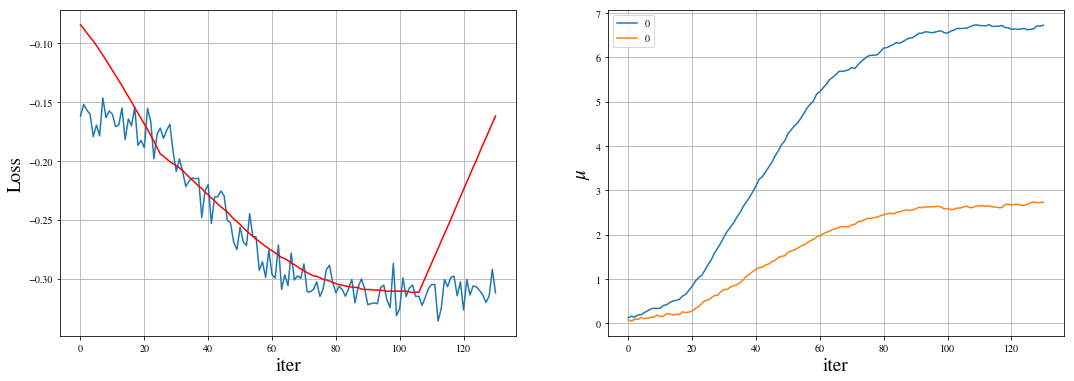

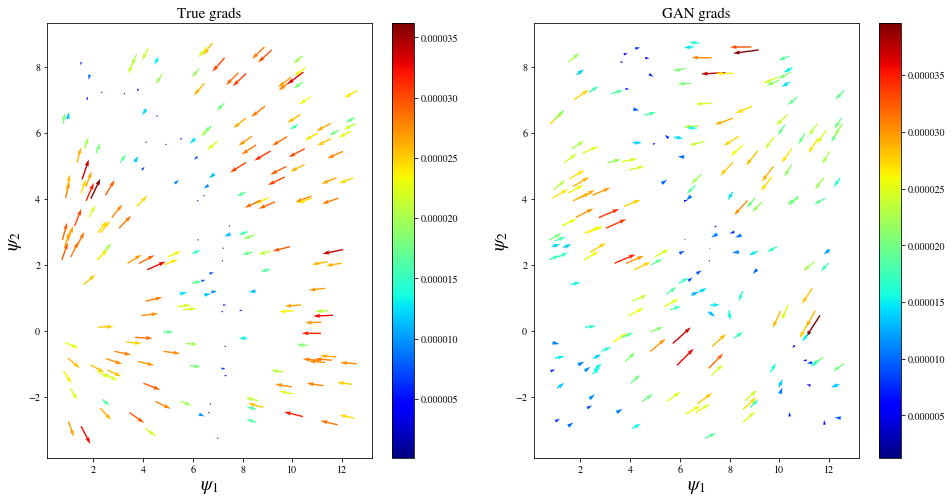

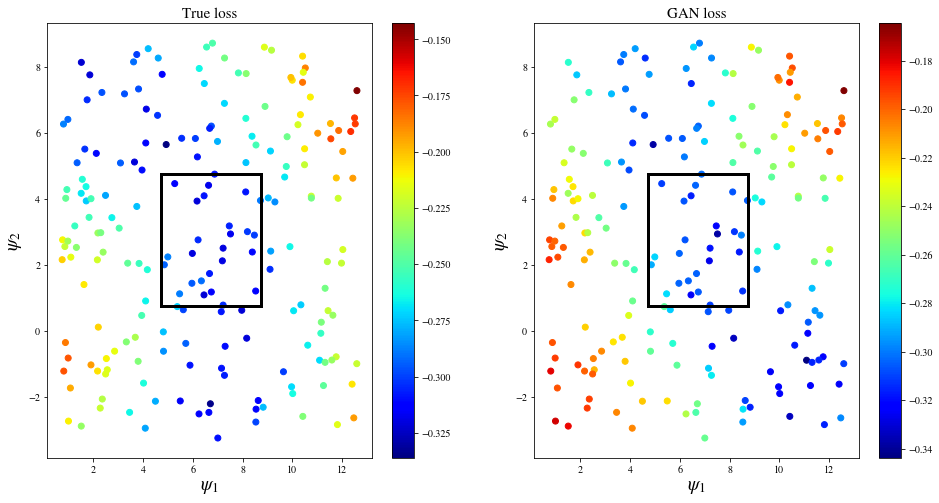

131


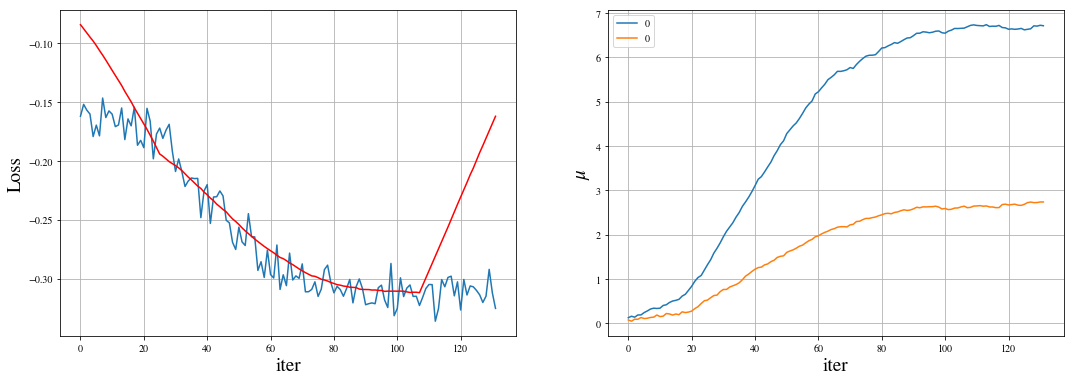

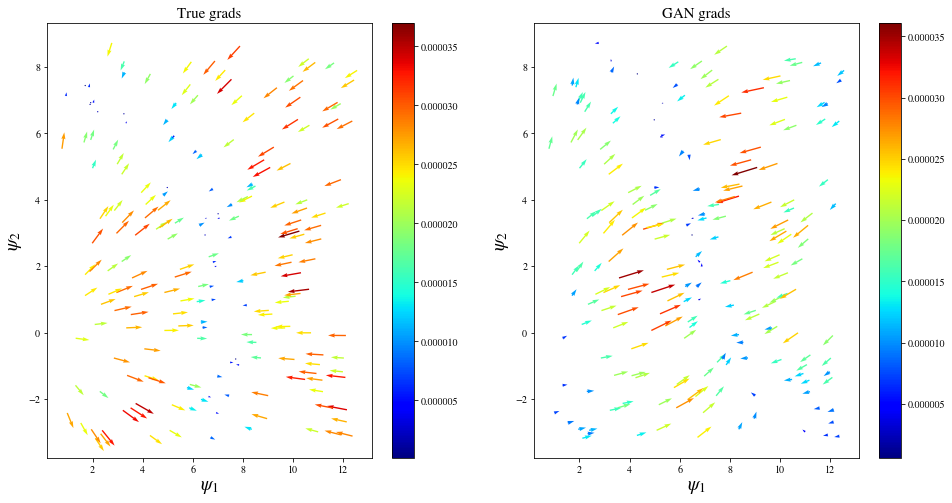

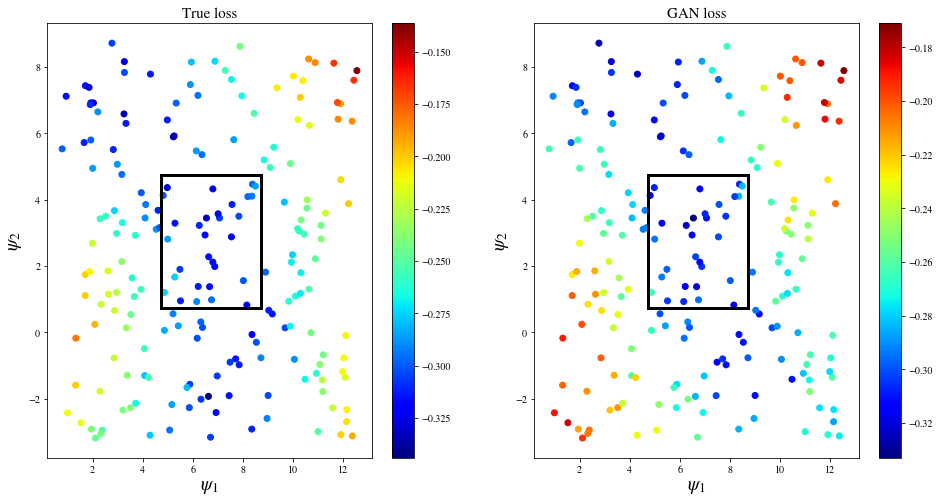

132


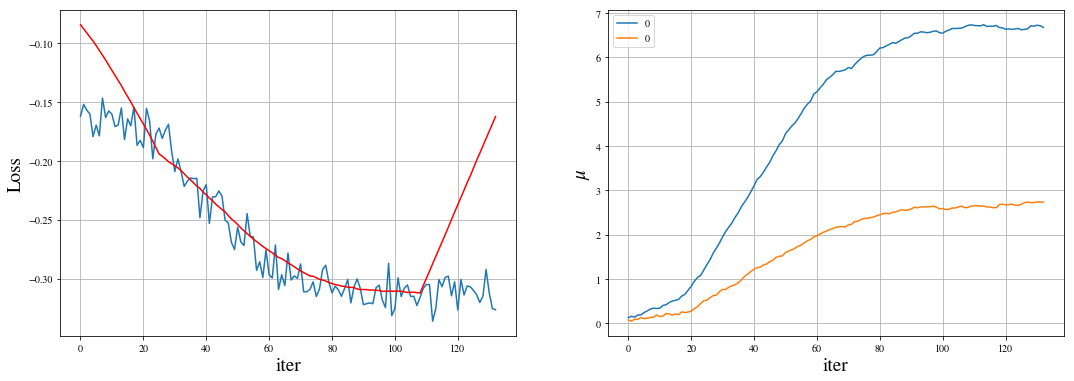

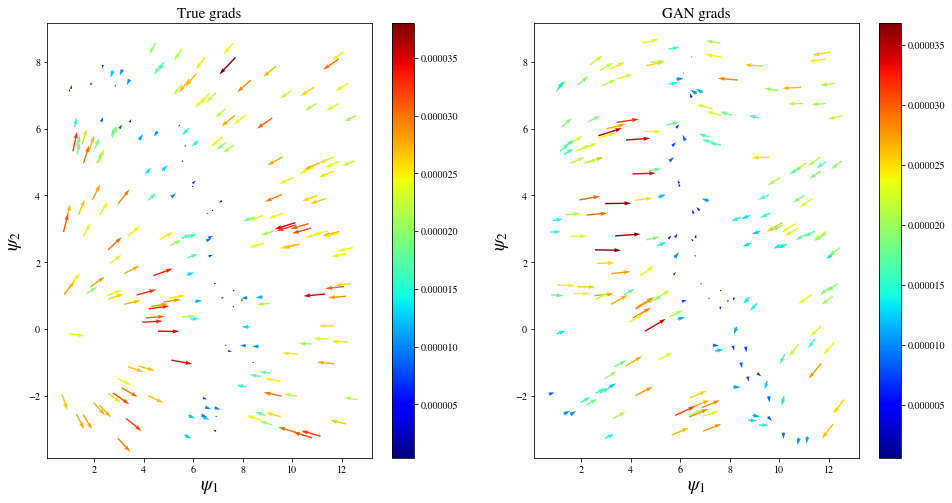

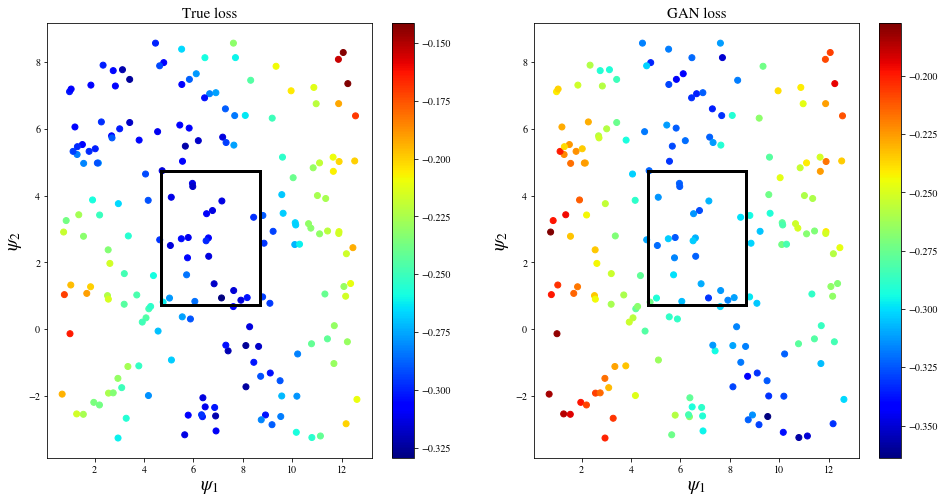

133


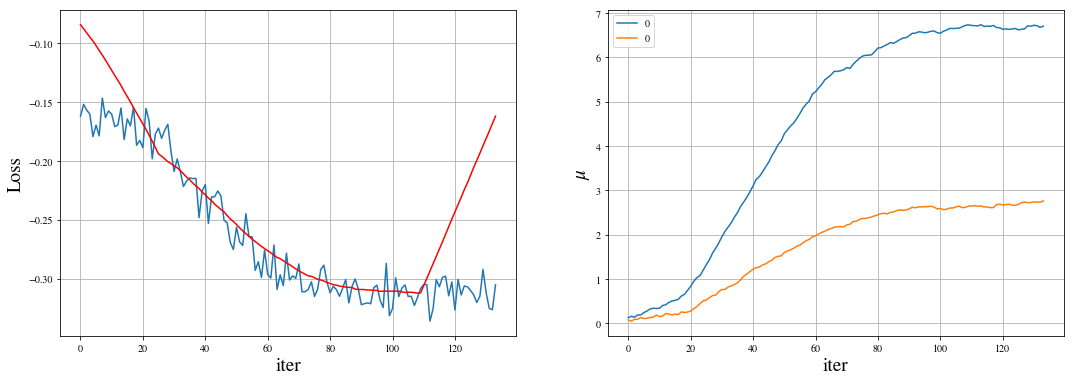

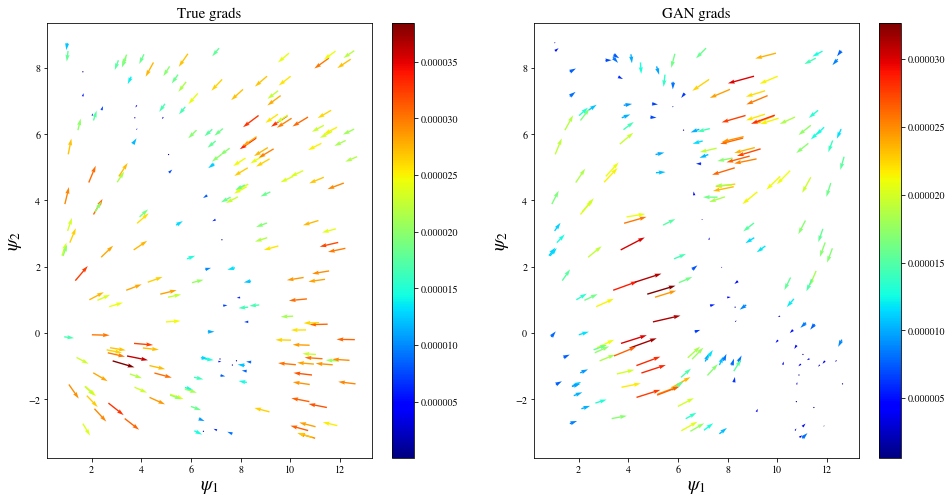

In [ ]:
end_to_end_training(current_psi=torch.tensor([[0.1, 0.1]]).float().to(device))